# Análisis Comparativo: Dual-Stream vs Tri-Stream Gating

Comparación directa entre arquitecturas **Nuevodual_stream_lstm_cnn** (baseline) y **tri_stream_gating** (con mecanismo de gating multiplicativo) para plantas 239/305/309/346 con ventanas históricas 11h/24h.

In [15]:
# Setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = Path.cwd().parent
sys.path.insert(0, str(BASE_DIR))

from src.config import get_plant_config

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['font.size'] = 10

print("✅ Setup completado")

✅ Setup completado


## 1. Cargar Resumen de Entrenamiento

In [16]:
# Cargar training_summary.csv
SUMMARY_PATH = BASE_DIR / 'figures' / 'training_summary.csv'
summary_df = pd.read_csv(SUMMARY_PATH)

# Filtrar solo modelos 48h output
summary_df = summary_df[summary_df['out_steps'] == 48].copy()

# FILTRAR: Solo Nuevodual_stream_lstm_cnn y tri_stream_gating
mask_nuevodual = summary_df['model_name'].str.contains('Nuevodual_stream_lstm_cnn', na=False)
mask_tri = summary_df['model_name'].str.contains('tri_stream_gating', na=False)
summary_df = summary_df[mask_nuevodual | mask_tri].copy()

# Filtrar solo ventanas 11h y 24h
summary_df = summary_df[summary_df['in_steps'].isin([11, 24])].copy()

print(f"✅ Cargados {len(summary_df)} modelos filtrados (Nuevodual + Tri-Stream, 11h/24h)")
print(f"\nPlantas: {sorted(summary_df['model_name'].str.extract(r'_(\d{3})_')[0].dropna().astype(int).unique())}")
print(f"Ventanas: {sorted(summary_df['in_steps'].unique())}h")
print(f"Arquitecturas: {summary_df['model_name'].apply(lambda x: 'Nuevodual' if 'Nuevodual' in x else 'Tri-Stream').unique().tolist()}")

✅ Cargados 26 modelos filtrados (Nuevodual + Tri-Stream, 11h/24h)

Plantas: [np.int64(239), np.int64(305), np.int64(309), np.int64(346)]
Ventanas: [np.int64(11), np.int64(24)]h
Arquitecturas: ['Nuevodual', 'Tri-Stream']


In [17]:
# Parser simplificado para modelos filtrados
def parse_model_name(name):
    """Extrae tipo, planta, in_steps del nombre del modelo"""
    parts = name.replace('.keras', '').split('_')
    
    # Detectar arquitectura
    if 'Nuevodual' in name:
        tipo = 'Dual-Stream (Nuevo)'
    elif 'tri_stream_gating' in name:
        tipo = 'Tri-Stream Gating'
    else:
        tipo = 'Otro'
    
    # Extraer planta (3 dígitos)
    planta = None
    for part in parts:
        if part.isdigit() and len(part) == 3:
            planta = int(part)
            break
    
    # Extraer in_steps (formato Xh)
    in_steps = None
    for part in parts:
        if part.endswith('h') and part[:-1].isdigit():
            in_steps = int(part[:-1])
            break
    
    return tipo, planta, in_steps

# Aplicar parser
summary_df['tipo'] = summary_df['model_name'].apply(lambda x: parse_model_name(x)[0])
summary_df['planta'] = summary_df['model_name'].apply(lambda x: parse_model_name(x)[1])
summary_df['in_steps_parsed'] = summary_df['model_name'].apply(lambda x: parse_model_name(x)[2])

# Etiqueta completa
summary_df['modelo_completo'] = summary_df.apply(
    lambda row: f"{row['tipo']}_{row['planta']}_{row['in_steps']}h", 
    axis=1
)

print(f"✅ Metadata extraída: {len(summary_df)} modelos procesados")
print(f"\nArquitecturas detectadas:")
for tipo in summary_df['tipo'].unique():
    count = len(summary_df[summary_df['tipo'] == tipo])
    print(f"   - {tipo}: {count} modelos")

✅ Metadata extraída: 26 modelos procesados

Arquitecturas detectadas:
   - Dual-Stream (Nuevo): 13 modelos
   - Tri-Stream Gating: 13 modelos


## 2. Tabla Comparativa General

In [18]:
# Crear tabla comparativa
tabla = summary_df[['modelo_completo', 'planta', 'tipo', 'in_steps', 
                     'test_mae', 'best_val_mae', 'total_time_minutes']].copy()
tabla = tabla.sort_values(['planta', 'tipo', 'in_steps'])

# Formatear
tabla['test_mae_pct'] = (tabla['test_mae'] * 100).round(2)
tabla['val_mae_pct'] = (tabla['best_val_mae'] * 100).round(2)
tabla['tiempo_min'] = tabla['total_time_minutes'].round(1)

# Display top 20
display(tabla[['modelo_completo', 'test_mae_pct', 'val_mae_pct', 'tiempo_min']].head(20))

print(f"\n📊 Estadísticas Generales:")
print(f"   Test MAE mínimo: {tabla['test_mae_pct'].min():.2f}%")
print(f"   Test MAE máximo: {tabla['test_mae_pct'].max():.2f}%")
print(f"   Test MAE promedio: {tabla['test_mae_pct'].mean():.2f}%")

,modelo_completo,test_mae_pct,val_mae_pct,tiempo_min
17,Dual-Stream (Nuevo)_239_11h,7.30,7.08,1.8
10,Dual-Stream (Nuevo)_239_24h,6.69,7.00,2.5
18,Dual-Stream (Nuevo)_239_24h,6.93,7.30,3.1
38,Tri-Stream Gating_239_11h,7.17,4.18,2.0
32,Tri-Stream Gating_239_24h,6.38,4.02,4.3
33,Tri-Stream Gating_239_24h,6.76,4.12,4.0
22,Dual-Stream (Nuevo)_305_11h,12.37,6.76,3.6
23,Dual-Stream (Nuevo)_305_24h,11.27,6.43,4.2
37,Tri-Stream Gating_305_11h,5.46,6.69,0.8
26,Tri-Stream Gating_305_24h,12.01,8.00,2.0



📊 Estadísticas Generales:
   Test MAE mínimo: 2.24%
   Test MAE máximo: 15.06%
   Test MAE promedio: 8.84%


## 3. Ranking por Planta (Top 5)

In [19]:
# Ranking por planta
for planta in sorted(summary_df['planta'].unique()):
    df_planta = summary_df[summary_df['planta'] == planta].sort_values('test_mae')
    plant_config = get_plant_config(planta)
    
    print(f"\n{'='*80}")
    print(f"🏭 PLANTA {planta} - {plant_config['nombre']} ({plant_config['potencia_mw']} MW)")
    print(f"{'='*80}")
    
    for idx, (i, row) in enumerate(df_planta.head(5).iterrows(), 1):
        print(f"   {idx}. {row['modelo_completo']:<50} | MAE: {row['test_mae']*100:>6.2f}% | Tiempo: {row['total_time_minutes']:>5.1f}min")


🏭 PLANTA 239 - SDGX01 (1.28 MW)
   1. Tri-Stream Gating_239_24h                          | MAE:   6.38% | Tiempo:   4.3min
   2. Dual-Stream (Nuevo)_239_24h                        | MAE:   6.69% | Tiempo:   2.5min
   3. Tri-Stream Gating_239_24h                          | MAE:   6.76% | Tiempo:   4.0min
   4. Dual-Stream (Nuevo)_239_24h                        | MAE:   6.93% | Tiempo:   3.1min
   5. Tri-Stream Gating_239_11h                          | MAE:   7.17% | Tiempo:   2.0min

🏭 PLANTA 305 - Las Terrazas (2.99 MW)
   1. Tri-Stream Gating_305_24h                          | MAE:   4.54% | Tiempo:   1.5min
   2. Tri-Stream Gating_305_11h                          | MAE:   5.46% | Tiempo:   0.8min
   3. Tri-Stream Gating_305_24h                          | MAE:  11.05% | Tiempo:   1.2min
   4. Dual-Stream (Nuevo)_305_24h                        | MAE:  11.27% | Tiempo:   4.2min
   5. Tri-Stream Gating_305_24h                          | MAE:  12.01% | Tiempo:   2.0min

🏭 PLANTA 309 - Ta

## 4. Visualizaciones Comparativas

### 4.1 Test MAE por Planta y Arquitectura

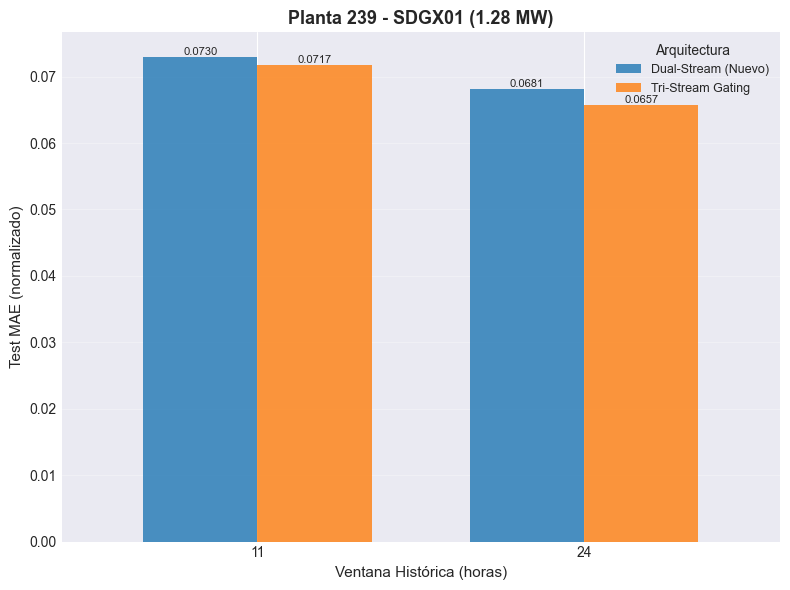

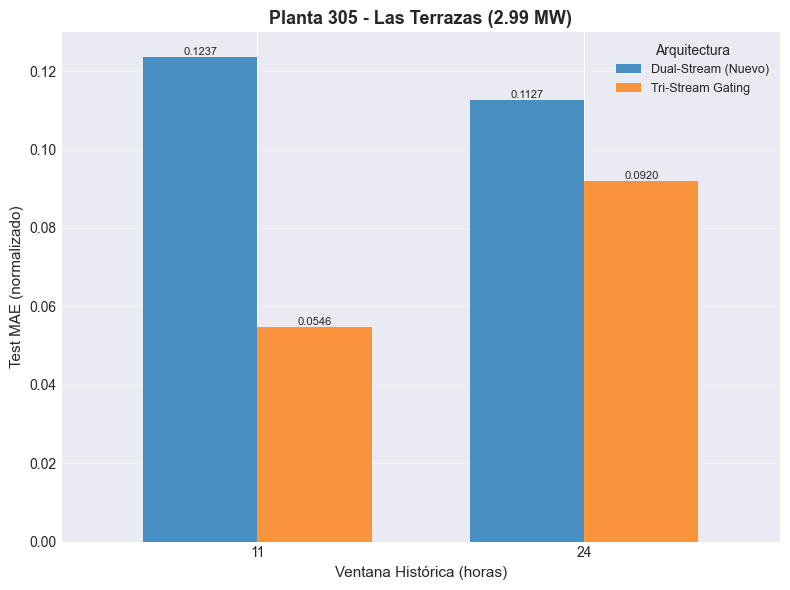

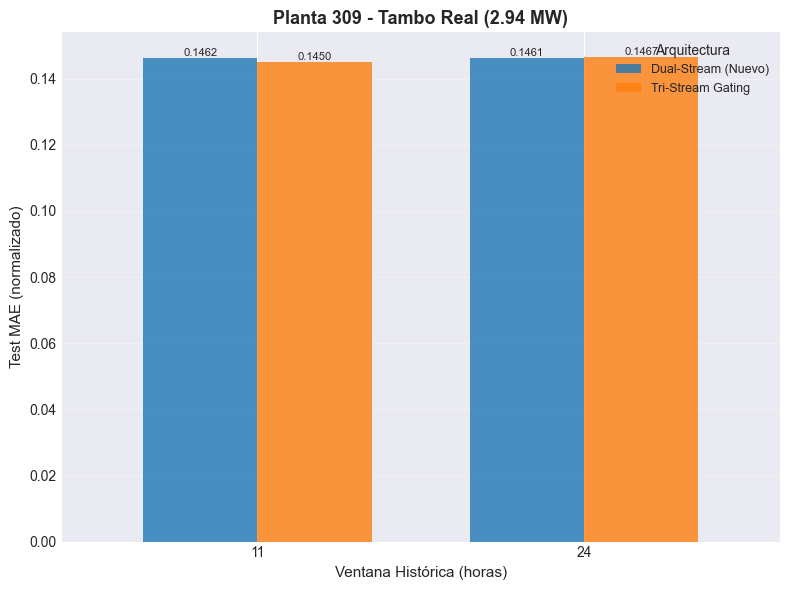

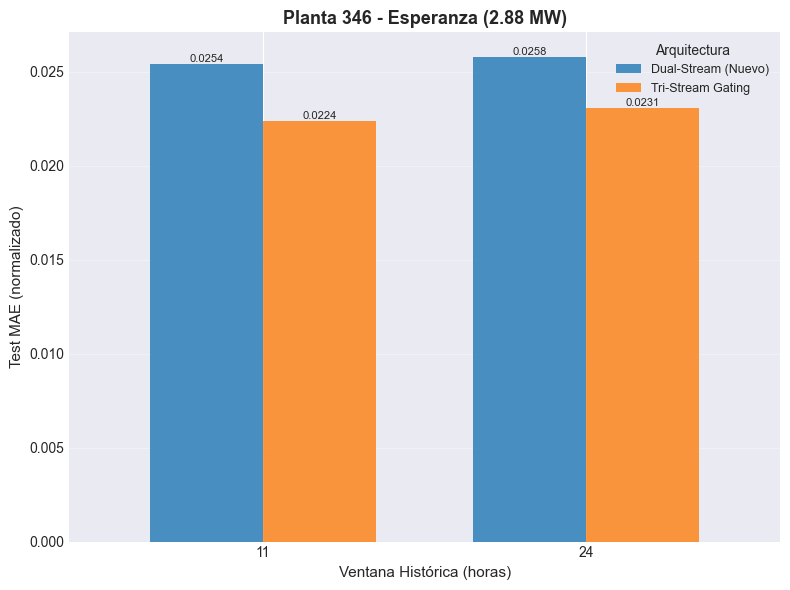

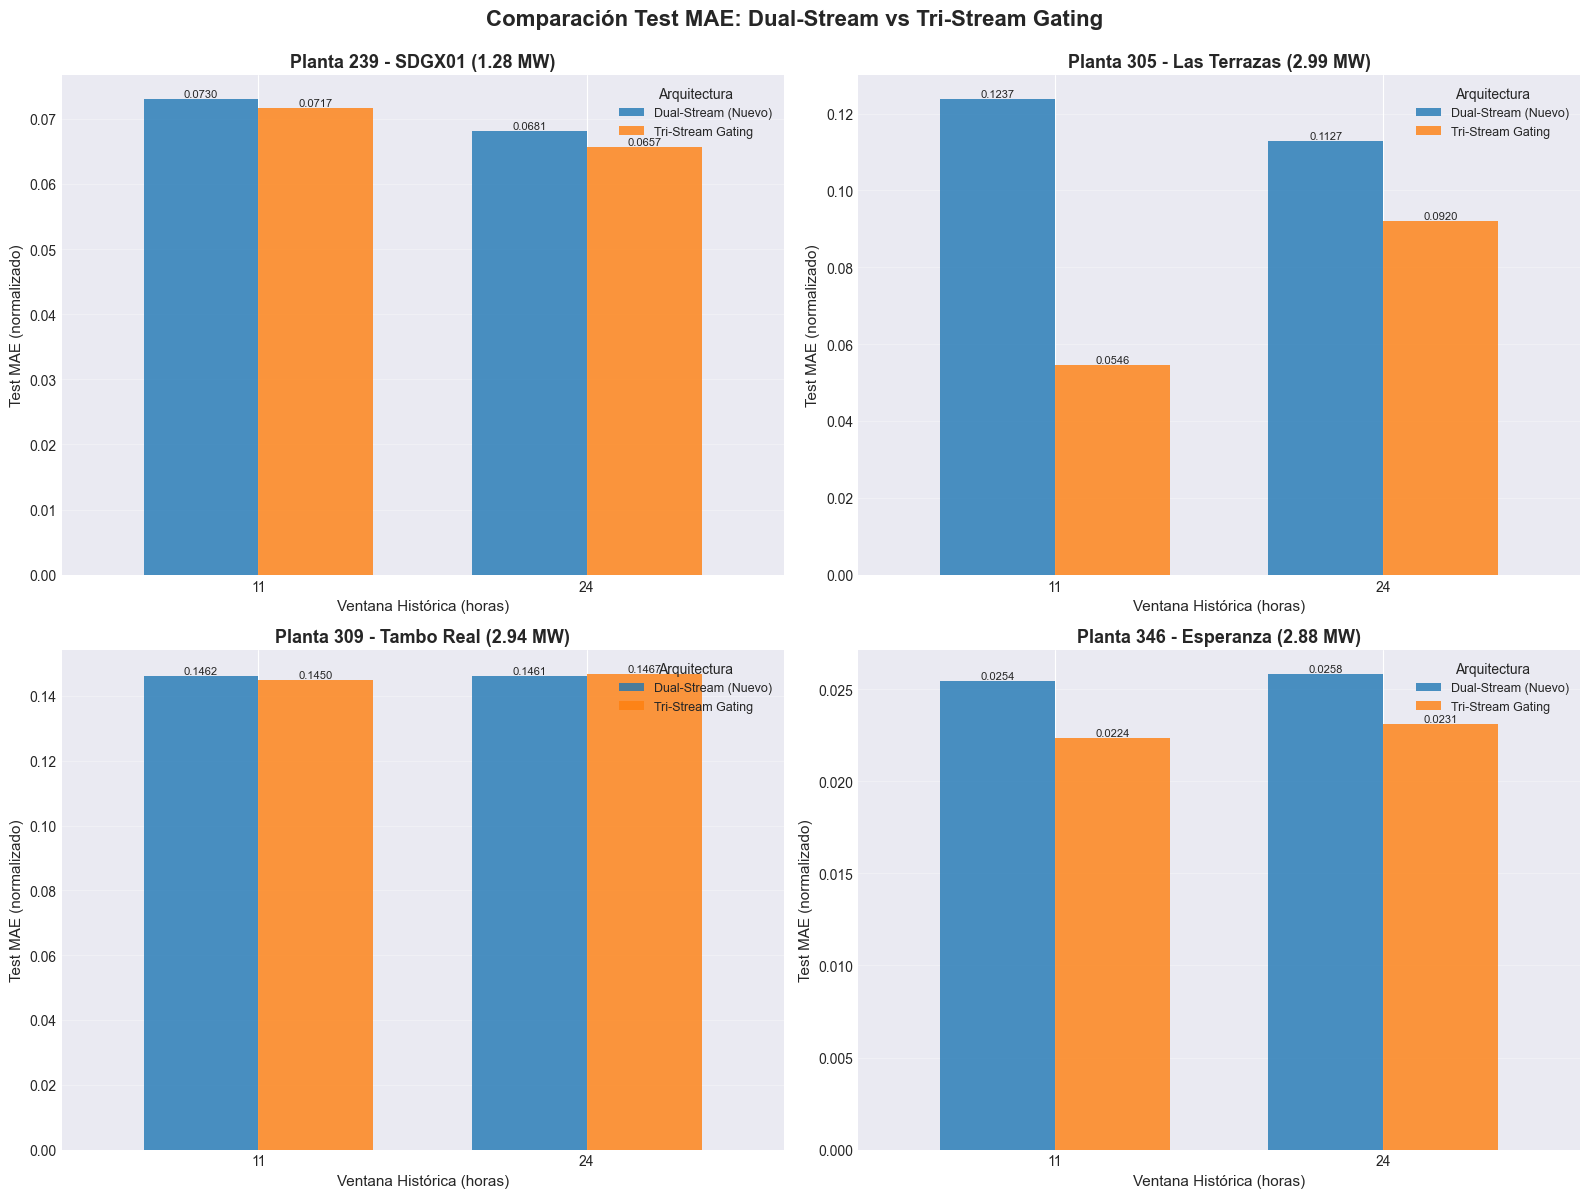

In [20]:
# Colores personalizados
colores = ['#1f77b4', '#ff7f0e']  # Azul y Naranja

# PARTE 1: Gráficos individuales por planta
plantas = sorted(summary_df['planta'].unique())

for planta in plantas:
    df_planta = summary_df[summary_df['planta'] == planta].copy()
    pivot_data = df_planta.pivot_table(
        values='test_mae', 
        index='in_steps', 
        columns='tipo',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(8, 6))
    pivot_data.plot(kind='bar', ax=ax, width=0.7, alpha=0.8, color=colores)
    
    plant_config = get_plant_config(planta)
    ax.set_title(f'Planta {planta} - {plant_config["nombre"]} ({plant_config["potencia_mw"]} MW)', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Ventana Histórica (horas)', fontsize=11)
    ax.set_ylabel('Test MAE (normalizado)', fontsize=11)
    ax.legend(title='Arquitectura', fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    # Valores en barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# PARTE 2: Todos los gráficos de barras en una sola figura (2x2)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, planta in enumerate(plantas):
    ax = axes[idx // 2, idx % 2]
    df_planta = summary_df[summary_df['planta'] == planta].copy()
    
    pivot_data = df_planta.pivot_table(
        values='test_mae', 
        index='in_steps', 
        columns='tipo',
        aggfunc='mean'
    )
    
    pivot_data.plot(kind='bar', ax=ax, width=0.7, alpha=0.8, color=colores)
    
    plant_config = get_plant_config(planta)
    ax.set_title(f'Planta {planta} - {plant_config["nombre"]} ({plant_config["potencia_mw"]} MW)', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Ventana Histórica (horas)', fontsize=11)
    ax.set_ylabel('Test MAE (normalizado)', fontsize=11)
    ax.legend(title='Arquitectura', fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    # Valores en barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', fontsize=8)

plt.suptitle('Comparación Test MAE: Dual-Stream vs Tri-Stream Gating', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 4.4 Heatmap: MAE por Planta y Configuración

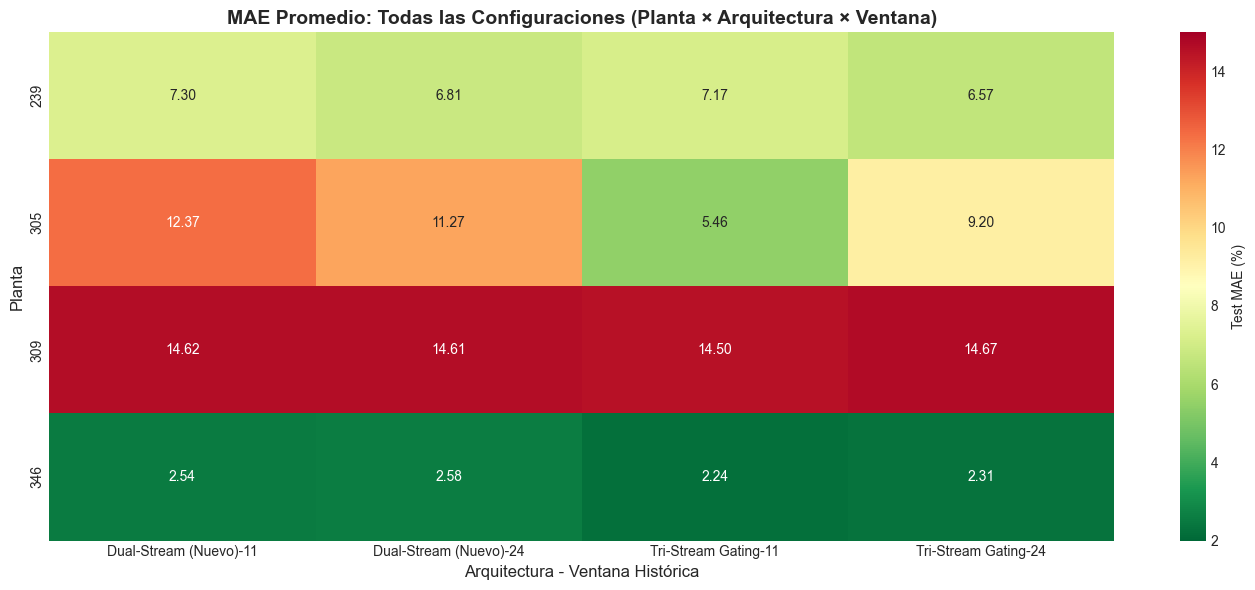

In [21]:
# Heatmap MAE promedio
pivot_heatmap = summary_df.pivot_table(
    values='test_mae',
    index='planta',
    columns=['tipo', 'in_steps'],
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(pivot_heatmap * 100, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            ax=ax, cbar_kws={'label': 'Test MAE (%)'}, vmin=2, vmax=15)
ax.set_title('MAE Promedio: Todas las Configuraciones (Planta × Arquitectura × Ventana)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Arquitectura - Ventana Histórica', fontsize=12)
ax.set_ylabel('Planta', fontsize=12)
plt.tight_layout()
plt.show()